In [112]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mne import Epochs, find_events, concatenate_epochs
from utils.loader import load_data, unicorn_fs, convert_to_mne, unicorn_eeg_channels
import mne
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import pickle
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from utils.validation import plot_feature_vector, plot_confusion_matrix, plot_cross_validated_confusion_matrix, plot_data_distribution

mne.set_log_level(verbose='ERROR', return_old_level=False, add_frames=None)

%matplotlib inline
#matplotlib.use("Qt5Agg")

path_dataset = 'data/dataset/listening'
labels = ['relax', 'excited']

### Preprocessing

1. Read Data
2. Generate Samples 
3. Extract Bands
4. Extract Features
5. Subtract Baseline 

##### 1. Read Data

In [98]:
# Baseline
path_folder = os.path.join(path_dataset, 'baseline')
files = [f for f in os.listdir(path_folder) if f.endswith('.csv')]
path_file = os.path.join(path_folder, files[0])
eeg_baseline = load_data(path_file, header=False, fs=unicorn_fs, names = unicorn_eeg_channels)[0]


# Relax
path_folder = os.path.join(path_dataset, 'relax')
files = [f for f in os.listdir(path_folder) if f.endswith('.csv')]
path_file = os.path.join(path_folder, files[0])
eeg_relax = load_data(path_file, header=False, fs=unicorn_fs, names = unicorn_eeg_channels)[0]

# Excited
path_folder = os.path.join(path_dataset, 'excited')
files = [f for f in os.listdir(path_folder) if f.endswith('.csv')]
path_file = os.path.join(path_folder, files[0])
eeg_excited = load_data(path_file, header=False, fs=unicorn_fs, names = unicorn_eeg_channels)[0]

##### 2. Generate Samples

The recording is divided in samples of duration 'window_duration' with an overlap percentage of 'window_overlap'

In [99]:
window_duration = 4 # seconds
window_size = window_duration * unicorn_fs # samples
window_overlap = 0.875 # percentage

# Baseline
eeg_baseline_samples = []
for i in range(0, len(eeg_baseline), int(window_size * (1 - window_overlap))):
    eeg_baseline_samples.append(eeg_baseline[i:i + window_size])

# Relax
eeg_relax_samples = []
for i in range(0, len(eeg_relax), int(window_size * (1 - window_overlap))):
    eeg_relax_samples.append(eeg_relax[i:i + window_size])

# Excited
eeg_excited_samples = []
for i in range(0, len(eeg_excited), int(window_size * (1 - window_overlap))):
    eeg_excited_samples.append(eeg_excited[i:i + window_size])

print('Sample dimension:', eeg_baseline_samples[0].shape)
print('Baseline samples:', len(eeg_baseline_samples))
print('Relax samples:', len(eeg_relax_samples))
print('Excited samples:', len(eeg_excited_samples))


Sample dimension: (1000, 8)
Baseline samples: 170
Relax samples: 470
Excited samples: 460


##### 3. Extract Bands
- theta (4-7 Hz)
- alpha (8-13 Hz) 
- low beta (14-21 Hz)
- high beta (22-29 Hz) 
- gamma (30-47 Hz)

In [100]:
def apply_filters(eeg):

    trigger = np.zeros(len(eeg))
    raw_data = convert_to_mne(eeg, trigger, fs=unicorn_fs, chs=unicorn_eeg_channels, recompute=False) 
    raw_data.notch_filter(50) 
    raw_data.notch_filter(60) 
    
    filtered_theta = raw_data.copy() 
    filtered_theta.filter(4, 7)

    filtered_alpha = raw_data.copy()
    filtered_alpha.filter(8, 13)

    filtered_low_beta = raw_data.copy()
    filtered_low_beta.filter(14, 17)

    filtered_high_beta = raw_data.copy()
    filtered_high_beta.filter(22, 29)

    filtered_gamma = raw_data.copy()
    filtered_gamma.filter(30, 47)

    filtered_sample = [filtered_theta.get_data()[0:8,:]*1e6, # without the STI channel and rescaled to microvolts
                       filtered_alpha.get_data()[0:8,:]*1e6, 
                       filtered_low_beta.get_data()[0:8,:]*1e6, 
                       filtered_high_beta.get_data()[0:8,:]*1e6, 
                       filtered_gamma.get_data()[0:8,:]*1e6]
    
    return np.array(filtered_sample)


In [101]:
filtered_baseline_samples = []
for i in range(len(eeg_baseline_samples)):
    print(f'Processing baseline sample: {i+1}/{len(eeg_baseline_samples)}', end='\r')
    sample = eeg_baseline_samples[i]
    filtered_baseline_samples.append(apply_filters(sample))
print()

filtered_relax_samples = []
for i in range(len(eeg_relax_samples)):
    print(f'Processing relax sample: {i+1}/{len(eeg_relax_samples)}', end='\r')
    sample = eeg_relax_samples[i]
    filtered_relax_samples.append(apply_filters(sample))
print()

filtered_excited_samples = []
for i in range(len(eeg_excited_samples)):
    print(f'Processing excited sample: {i+1}/{len(eeg_excited_samples)}', end='\r')
    sample = eeg_excited_samples[i]
    filtered_excited_samples.append(apply_filters(sample))

print('\nFinished processing samples')

Processing baseline sample: 170/170
Processing relax sample: 470/470
Processing excited sample: 460/460
Finished processing samples


##### 4. Feature Extraction

For each sample, for each band (5), for each channel (8), compute the log-variance on the signal.
In total we obtain 5*8 = 40 features for each sample


In [102]:
def log_var_transform(samples):
    log_var_samples = []
    for i in range(len(samples)):
        sample = samples[i]
        # reshape to (bands, channels, samples) 
        sample = np.transpose(sample, (0, 1, 2))
        # calculate the log-variance
        log_var_sample = np.log(np.var(sample, axis=2))
        # flatten to one dimension
        log_var_sample = log_var_sample.flatten()
        log_var_samples.append(log_var_sample)
    return np.array(log_var_samples)

In [103]:
features_baseline_samples = log_var_transform(filtered_baseline_samples)
features_relax_samples = log_var_transform(filtered_relax_samples)
features_excited_samples = log_var_transform(filtered_excited_samples)

print('Log var baseline samples:', features_baseline_samples.shape)
print('Log var relax samples:', features_relax_samples.shape)
print('Log var excited samples:', features_excited_samples.shape)

Log var baseline samples: (170, 40)
Log var relax samples: (470, 40)
Log var excited samples: (460, 40)


##### 5. Baseline Subtruction


In [104]:
# avarage baseline samples to get a single baseline vector
baseline = np.mean(features_baseline_samples, axis=0)

# calculate the difference between the baseline and the relax/excited samples
diff_relax = features_relax_samples - baseline
diff_excited = features_excited_samples - baseline

print('Baseline:', baseline.shape)
print('Diff relax:', diff_relax.shape)
print('Diff excited:', diff_excited.shape)

Baseline: (40,)
Diff relax: (470, 40)
Diff excited: (460, 40)


#### Linear Discriminant Analysis (LDA)

At this step, classification of the data is made by using the LDA

In [105]:
X = np.vstack((diff_relax, diff_excited))
y = np.hstack((np.zeros(len(diff_relax)), np.ones(len(diff_excited))))

print(X.shape, y.shape)

(930, 40) (930,)


In [106]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(744, 40) (186, 40) (744,) (186,)


Accuracy: 0.96 F1 Score: 0.96


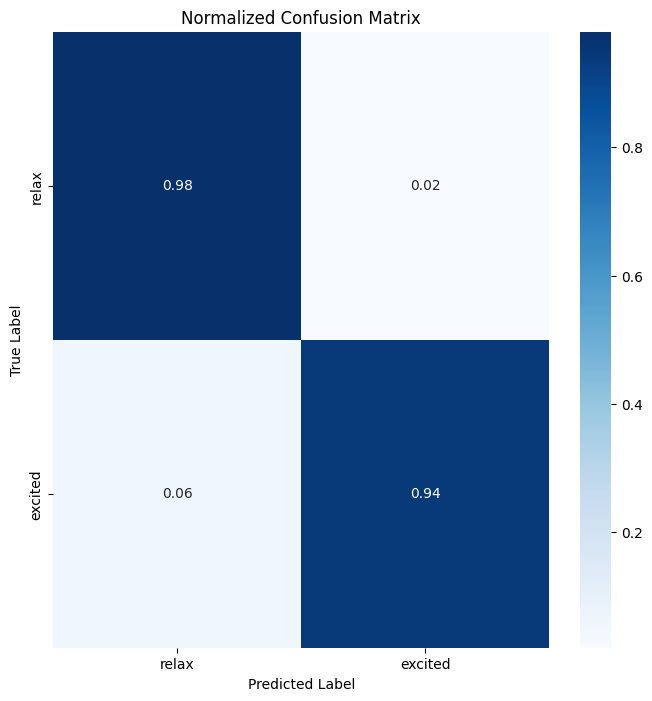

In [114]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 


# Apply LDA
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

# Save the model
outfile = 'models/lda_model.pkl'
with open(outfile, 'wb') as pickle_file:
    pickle.dump(model, pickle_file)


# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Accuracy: {accuracy:.2f} F1 Score: {f1:.2f}')
plot_confusion_matrix(y_test, y_pred, classes=labels, normalize=True)


Accuracy: 0.97 F1 Score: 0.97


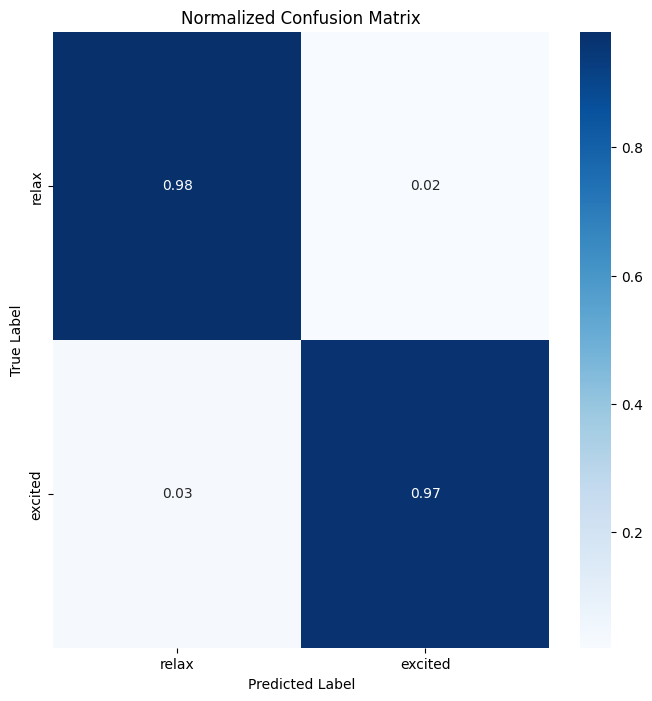

In [115]:
# SVM
from sklearn import svm
model = svm.SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# save the model
outfile = 'models/svm_model.pkl'
with open(outfile, 'wb') as pickle_file:
    pickle.dump(model, pickle_file)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Accuracy: {accuracy:.2f} F1 Score: {f1:.2f}')
plot_confusion_matrix(y_test, y_pred, classes=labels, normalize=True)

Cross-validated accuracy: 0.96 (+/- 0.02) F1-Score: 0.96


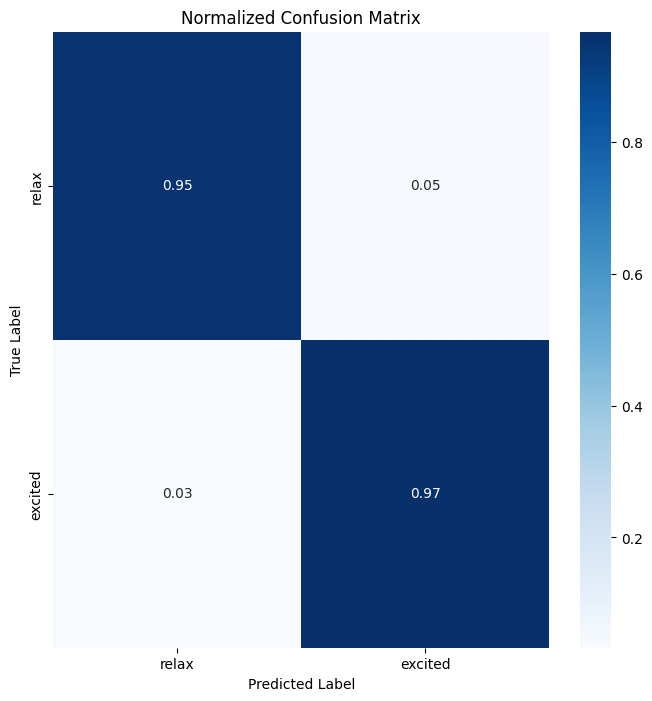

In [111]:
scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X)

# Use cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_rescaled, y, cv=cv)
f1 = cross_val_score(model, X_rescaled, y, cv=cv, scoring='f1', error_score=0)

# Print cross-validated accuracy
print(f'Cross-validated accuracy: {np.mean(scores):.2f} (+/- {np.std(scores):.2f}) F1-Score: {np.mean(f1):.2f}')

plot_cross_validated_confusion_matrix(X_rescaled, y, model, cv=cv, classes=labels, normalize=True)